In [1]:
from pathlib import Path

run_id = "uirlcewv"
run_dir = Path(
    f"/net/csefiles/coc-fung-cluster/nima/shared/experiment-data/lltrainer/{run_id}/"
)
assert (
    run_dir.exists() and run_dir.is_dir()
), f"run_dir: {run_dir} does not exist or is not a directory"
print(run_dir)

/net/csefiles/coc-fung-cluster/nima/shared/experiment-data/lltrainer/uirlcewv


In [2]:
def make_config():
    from collections.abc import Callable
    from pathlib import Path
    from typing import Literal

    import nshtrainer as nt
    from jmppeft.configs.finetune.jmp_s import jmp_s_ft_config_
    from jmppeft.modules import loss
    from jmppeft.tasks.config import AdamWConfig
    from jmppeft.tasks.finetune import base, output_head
    from jmppeft.tasks.finetune import matbench_discovery as M
    from jmppeft.utils.param_specific_util import (
        make_parameter_specific_optimizer_config,
        parameter_specific_optimizer_config,
    )

    jmp_s_ckpt_path = Path(
        "/net/csefiles/coc-fung-cluster/nima/shared/checkpoints/jmp-s.pt"
    )

    # Set this to None if you want the run logs to be saved in the current directory
    project_root: Path | None = Path(
        "/net/csefiles/coc-fung-cluster/nima/shared/experiment-data/"
    )
    project_root.mkdir(exist_ok=True, parents=True)

    def jmp_s_(config: base.FinetuneConfigBase):
        ckpt_path = jmp_s_ckpt_path
        assert ckpt_path.exists(), f"Checkpoint not found: {ckpt_path}"

        jmp_s_ft_config_(config)
        config.ckpt_load.checkpoint = base.PretrainedCheckpointConfig(
            path=ckpt_path, ema=True
        )

        config.meta["jmp_kind"] = "s"
        config.name_parts.append("jmps")

    def parameter_specific_optimizers_(config: base.FinetuneConfigBase):
        if config.parameter_specific_optimizers is None:
            config.parameter_specific_optimizers = []

        match config.meta["jmp_kind"]:
            case "l":
                config.parameter_specific_optimizers.extend(
                    make_parameter_specific_optimizer_config(
                        config,
                        config.backbone.num_blocks,
                        {
                            "embedding": 0.3,
                            "blocks_0": 0.55,
                            "blocks_1": 0.40,
                            "blocks_2": 0.30,
                            "blocks_3": 0.40,
                            "blocks_4": 0.55,
                            "blocks_5": 0.625,
                        },
                    )
                )
            case "s":
                config.parameter_specific_optimizers.extend(
                    make_parameter_specific_optimizer_config(
                        config,
                        config.backbone.num_blocks,
                        {
                            "embedding": 0.3,
                            "blocks_0": 0.30,
                            "blocks_1": 0.40,
                            "blocks_2": 0.55,
                            "blocks_3": 0.625,
                        },
                    )
                )
            case _:
                raise ValueError(f"Invalid jmp_kind: {config.meta['jmp_kind']}")

    def parameter_specific_optimizers_energy_references_(
        config: base.FinetuneConfigBase,
        lr_multiplier: float = 0.1,
    ):
        if not config.parameter_specific_optimizers:
            config.parameter_specific_optimizers = []

        if energy_ref_heads := [
            t
            for t in config.graph_targets
            if isinstance(t, output_head.ReferencedScalarTargetConfig)
        ]:
            config.parameter_specific_optimizers.extend(
                parameter_specific_optimizer_config(
                    config,
                    [
                        {
                            "name": f"{energy_ref_head.name}.ref",
                            "lr_multiplier": lr_multiplier,
                            "parameter_patterns": [
                                f"graph_outputs._module_dict.ft_mlp_{energy_ref_head.name}.references.*"
                            ],
                        }
                        for energy_ref_head in energy_ref_heads
                    ],
                )
            )

        elif allegro_heads := [
            t
            for t in config.graph_targets
            if isinstance(t, output_head.AllegroScalarTargetConfig)
        ]:
            config.parameter_specific_optimizers.extend(
                parameter_specific_optimizer_config(
                    config,
                    [
                        {
                            "name": f"{h.name}.scales",
                            "lr_multiplier": lr_multiplier,
                            "parameter_patterns": [
                                f"graph_outputs._module_dict.ft_mlp_{h.name}.per_atom_scales.*",
                                f"graph_outputs._module_dict.ft_mlp_{h.name}.per_atom_shifts.*",
                                *(
                                    [
                                        f"graph_outputs._module_dict.ft_mlp_{h.name}.pairwise_scales.*"
                                    ]
                                    if h.edge_level_energies
                                    else []
                                ),
                            ],
                        }
                        for h in allegro_heads
                    ],
                )
            )
        else:
            raise ValueError("No energy reference or allegro heads found")

    def direct_(config: base.FinetuneConfigBase):
        config.backbone.regress_forces = True
        config.backbone.direct_forces = True
        config.backbone.regress_energy = True
        config.name_parts.append("direct")

    def ln_(
        config: base.FinetuneConfigBase,
        *,
        lr_multiplier: float | None,
    ):
        config.backbone.ln_per_layer = True
        config.backbone.scale_factor_to_ln = True

        if lr_multiplier is not None:
            if config.parameter_specific_optimizers is None:
                config.parameter_specific_optimizers = []

            config.parameter_specific_optimizers = [
                *parameter_specific_optimizer_config(
                    config,
                    [
                        {
                            "name": "ln",
                            "lr_multiplier": lr_multiplier,
                            "parameter_patterns": [
                                "backbone.h_lns.*",
                                "backbone.m_lns.*",
                                "backbone.*.scale*.ln.*",
                            ],
                        }
                    ],
                ),
                *config.parameter_specific_optimizers,
            ]

        config.name_parts.append("ln")

    def pos_aug_(config: base.FinetuneConfigBase, *, std: float):
        config.pos_noise_augmentation = base.PositionNoiseAugmentationConfig(
            system_corrupt_prob=0.75,
            atom_corrupt_prob=0.5,
            noise_std=std,
        )
        config.name_parts.append(f"posaug_std{std}")

    def data_config_(
        config: M.MatbenchDiscoveryConfig,
        *,
        batch_size: int,
        reference: bool,
    ):
        config.batch_size = batch_size
        config.name_parts.append(f"bsz{batch_size}")

        def dataset_fn(split: Literal["train", "val", "test"]):
            return base.FinetuneMPTrjHuggingfaceDatasetConfig(
                split=split,
                energy_column_mapping={
                    "y": "corrected_total_energy_referenced",
                    "y_relaxed": "corrected_total_energy_relaxed_referenced",
                }
                if reference
                else {
                    "y": "corrected_total_energy",
                    "y_relaxed": "corrected_total_energy_relaxed",
                },
            )

        config.train_dataset = dataset_fn("train")
        config.val_dataset = dataset_fn("val")
        config.test_dataset = dataset_fn("test")

        if reference:
            config.name_parts.append("linrefenergy")
        else:
            config.name_parts.append("totalenergy")

        # Set data config
        config.num_workers = 7

        # Balanced batch sampler
        config.use_balanced_batch_sampler = True
        config.trainer.use_distributed_sampler = False

    def output_heads_config_(
        config: M.MatbenchDiscoveryConfig,
        *,
        relaxed_energy: bool,
        mace_energy_loss: bool,
        mace_force_loss: bool,
        energy_coefficient: float,
        force_coefficient: float,
        stress_coefficient: float,
    ):
        energy_loss = loss.HuberLossConfig(delta=0.01)
        if mace_energy_loss:
            energy_loss = loss.MACEHuberEnergyLossConfig(delta=0.01)
            config.name_parts.append("maceenergy")

        force_loss = loss.HuberLossConfig(delta=0.01)
        if mace_force_loss:
            force_loss = loss.MACEHuberLossConfig(delta=0.01)
            config.name_parts.append("maceforce")

        # Energy head
        config.graph_targets.append(
            output_head.AllegroScalarTargetConfig(
                name="y",
                loss_coefficient=energy_coefficient,
                loss=energy_loss.model_copy(),
                reduction="sum",
                max_atomic_number=config.backbone.num_elements,
                edge_level_energies=True,
            )
        )
        if relaxed_energy:
            # Relaxed Energy head
            config.graph_targets.append(
                output_head.AllegroScalarTargetConfig(
                    name="y_relaxed",
                    loss_coefficient=energy_coefficient / 2.0,
                    loss=energy_loss.model_copy(),
                    reduction="sum",
                    max_atomic_number=config.backbone.num_elements,
                    edge_level_energies=True,
                )
            )

            config.name_parts.append("rele")
        # Stress head
        config.graph_targets.append(
            output_head.DirectStressTargetConfig(
                name="stress",
                loss_coefficient=stress_coefficient,
                loss=loss.HuberLossConfig(delta=0.01),
                reduction="mean",
            )
        )
        # Force head
        config.node_targets.append(
            output_head.NodeVectorTargetConfig(
                name="force",
                loss_coefficient=force_coefficient,
                loss=force_loss,
                reduction="sum",
            )
        )

        config.name_parts.append(f"ec{energy_coefficient}")
        config.name_parts.append(f"fc{force_coefficient}")
        config.name_parts.append(f"sc{stress_coefficient}")

    def optimization_config_(
        config: M.MatbenchDiscoveryConfig,
        *,
        lr: float,
    ):
        config.optimizer = AdamWConfig(
            lr=lr,
            amsgrad=False,
            betas=(0.9, 0.95),
            weight_decay=0.1,
        )
        config.lr_scheduler = base.WarmupCosRLPConfig(
            warmup_epochs=1,
            warmup_start_lr_factor=1.0e-1,
            should_restart=False,
            max_epochs=128,
            min_lr_factor=0.5,
            rlp=base.RLPConfig(patience=5, factor=0.8),
        )
        config.trainer.optimizer.gradient_clipping = nt.model.GradientClippingConfig(
            value=2.0,
            algorithm="value",
        )

        config.name_parts.append(f"lr{lr}")

    def create_config(config_fn: Callable[[M.MatbenchDiscoveryConfig], None]):
        config = M.MatbenchDiscoveryConfig.draft()

        config.trainer.precision = "16-mixed-auto"
        config.trainer.set_float32_matmul_precision = "medium"

        config.project = "jmp_mptrj"
        config.name = "mptrj"
        config_fn(config)
        config.backbone.qint_tags = [0, 1, 2]

        config.primary_metric = nt.MetricConfig(
            name="matbench_discovery/force_mae", mode="min"
        )

        if project_root:
            config.with_project_root_(project_root)
        return config

    config = create_config(jmp_s_)
    config.parameter_specific_optimizers = []
    config.max_neighbors = M.MaxNeighbors(main=25, aeaint=20, aint=1000, qint=8)
    config.cutoffs = M.Cutoffs.from_constant(12.0)
    data_config_(config, reference=True, batch_size=40)
    optimization_config_(config, lr=8.0e-5)
    ln_(config, lr_multiplier=1.5)
    direct_(config=config)
    output_heads_config_(
        config,
        relaxed_energy=True,
        mace_energy_loss=True,
        mace_force_loss=True,
        energy_coefficient=5.0,
        force_coefficient=10.0,
        stress_coefficient=100.0,
    )
    parameter_specific_optimizers_(config)
    parameter_specific_optimizers_energy_references_(config, lr_multiplier=0.1)
    pos_aug_(config, std=0.01)
    config.per_graph_radius_graph = True
    config.ignore_graph_generation_errors = False

    config = config.finalize()

    return config


config = make_config()
config

TensorBoard/TensorBoardX not found. Disabling TensorBoardLogger. Please install TensorBoard with `pip install tensorboard` or TensorBoardX with `pip install tensorboardx` to enable TensorBoard logging.
Type checking the following modules: ('jmppeft',)
/net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/nshtrainer/model/config.py:1504: IdSeedWarning: BaseConfig._rng is None. The generated IDs will not be reproducible. To fix this, call BaseConfig.set_seed(...) before generating any IDs.
  warnings.warn(


MatbenchDiscoveryConfig(id='tsrzetma', name='mptrj', name_parts=['jmps', 'bsz40', 'linrefenergy', 'lr8e-05', 'ln', 'direct', 'maceenergy', 'maceforce', 'rele', 'ec5.0', 'fc10.0', 'sc100.0', 'posaug_std0.01'], project='jmp_mptrj', directory=DirectoryConfig(project_root=PosixPath('/net/csefiles/coc-fung-cluster/nima/shared/experiment-data')), trainer=TrainerConfig(optimizer=OptimizationConfig(log_grad_norm=True, gradient_clipping=GradientClippingConfig(value=2.0, algorithm='value')), early_stopping=EarlyStoppingConfig(patience=50, min_lr=1e-08), precision='fp16-mixed', max_epochs=500, max_time='07:00:00:00', use_distributed_sampler=False, set_float32_matmul_precision='medium'), primary_metric=MetricConfig(name='matbench_discovery/force_mae', mode='min'), meta={'jmp_kind': 's'}, train_dataset=FinetuneMPTrjHuggingfaceDatasetConfig(split='train', energy_column_mapping={'y': 'corrected_total_energy_referenced', 'y_relaxed': 'corrected_total_energy_relaxed_referenced'}), val_dataset=FinetuneM

In [3]:
import yaml

config_updated = config

hparams_file = next(run_dir.glob("./log/csv/csv/*/*/hparams.yaml"))
print(hparams_file)

key_keys = (
    "backbone",
    "embedding",
    "output",
    "graph_targets",
    "node_targets",
    "train_dataset",
    "val_dataset",
    "test_dataset",
    "id",
    "name",
    "name_parts",
    # "predict_dataset",
)

hparams = yaml.unsafe_load(hparams_file.read_text())

# Update the config with the hparams
for key in key_keys:
    assert (value := hparams.get(key)), f"{key} not found in hparams"

    config_dict = config_updated.model_dump(round_trip=True)
    config_dict[key] = value
    config_updated = config_updated.model_validate(config_dict, strict=True)

/net/csefiles/coc-fung-cluster/nima/shared/experiment-data/lltrainer/uirlcewv/log/csv/csv/mptrj-jmps-bsz16-linrefenergy-lr8e-05-ln-direct-maceenergy-maceforce-rele-ec2.0-fc10.0-sc100.0-posaug_std0.01/uirlcewv/hparams.yaml


In [4]:
import os

os.environ["LL_DISABLE_TYPECHECKING"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


import torch

torch.no_grad().__enter__()
torch.inference_mode().__enter__()

In [5]:
# ckpt_path = run_dir / "checkpoint" / "last.ckpt"
ckpt_path = next(run_dir.glob("checkpoint/latest_*.ckpt"))
# If the file is a symlink, get the target
if ckpt_path.is_symlink():
    print(f"Symlink found {ckpt_path} => {ckpt_path.resolve()}")
    ckpt_path = ckpt_path.resolve()

ckpt_path

PosixPath('/net/csefiles/coc-fung-cluster/nima/shared/experiment-data/lltrainer/uirlcewv/checkpoint/latest_epoch31_step724384.ckpt')

In [6]:
from jmppeft.tasks.finetune.base import FinetuneMatBenchDiscoveryIS2REDatasetConfig

dataset_config = FinetuneMatBenchDiscoveryIS2REDatasetConfig(
    # sample_n=DatasetSampleNConfig(sample_n=16, seed=42)
)
print(dataset_config)

dataset_og = dataset_config.create_dataset()
dataset_og, len(dataset_og)


Loading 'wbm_summary' from cached file at '/nethome/nsg6/.cache/matbench-discovery/1.0.0/wbm/2023-12-13-wbm-summary.csv.gz'


(<jmppeft.datasets.mpd_is2re.MatBenchDiscoveryIS2REDataset at 0x7f95dd318250>,
 256963)

In [9]:
from jmppeft.tasks.finetune import matbench_discovery as M

default_dtype = torch.float32
ckpt = torch.load(ckpt_path, map_location="cuda")

model = M.MatbenchDiscoveryModel(config_updated)
model = model.to(default_dtype).cuda().eval()
model.load_state_dict(ckpt["state_dict"])
model

[19:29:00] WARNING  NSHRUNNER_SESSION_DIR is not set. Skipping symlink creation.                      ]8;id=242578;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/nshtrainer/model/config.py\config.py]8;;\:]8;id=710622;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/nshtrainer/model/config.py#621\621]8;;\

           WARNING  NSHRUNNER_SESSION_DIR is not set. Skipping symlink creation.                      ]8;id=35720;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/nshtrainer/model/config.py\config.py]8;;\:]8;id=522257;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/nshtrainer/model/config.py#621\621]8;;\

           WARNING  NSHRUNNER_SESSION_DIR is not set. Skipping symlink creation.                      ]8;id=112932;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/nshtrainer/model/config.py\config.py]8;;\:]8;id=395956;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/nshtrainer/model/config.py#621\621]8;;\

           WARNING  NSHRUNNER_SESSION_DIR is not set. Skipping symlink creation.                      ]8;id=30733;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/nshtrainer/model/config.py\config.py]8;;\:]8;id=616353;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/nshtrainer/model/config.py#621\621]8;;\

           CRITICAL Using regular backbone                                                              ]8;id=851940;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py\base.py]8;;\:]8;id=113313;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py#611\611]8;;\

Unrecognized arguments:  dict_keys(['name', 'learnable_rbf', 'learnable_rbf_stds', 'unique_basis_per_layer', 'dropout', 'edge_dropout', 'ln_per_layer', 'scale_factor_to_ln'])


           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=708012;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=534168;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=189127;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=114401;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=877770;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=630049;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=250015;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=797670;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=926345;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=733436;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=689619;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=723692;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

           INFO     [RadialBasis] Using absolute cutoff of 12.0 Angstroms.       ]8;id=118846;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py\radial_basis_dynamic_cutoff.py]8;;\:]8;id=465187;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/models/gemnet/layers/radial_basis_dynamic_cutoff.py#213\213]8;;\

[19:29:05] CRITICAL Constructed backbone with dlora=None                                                ]8;id=632833;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py\base.py]8;;\:]8;id=113816;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py#622\622]8;;\

           INFO     Registered 12 shared parameters                                         ]8;id=355164;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/nshtrainer/model/modules/shared_parameters.py\shared_parameters.py]8;;\:]8;id=765532;file:///net/csefiles/coc-fung-cluster/nima/miniforge3/envs/jmp-peft/lib/python3.11/site-packages/nshtrainer/model/modules/shared_parameters.py#72\72]8;;\

           INFO     List of ignored parameters: []                                                      ]8;id=60377;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py\base.py]8;;\:]8;id=161032;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py#700\700]8;;\

           CRITICAL Freezing 0 parameters (0.00%) out of 43,146,824 total parameters (43,146,824        ]8;id=490821;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py\base.py]8;;\:]8;id=175887;file:///net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/src/jmppeft/tasks/finetune/base.py#929\929]8;;\
                    trainable)                                                                                     

MatbenchDiscoveryModel(config=MatbenchDiscoveryConfig(name=mptrj-jmps-bsz16-linrefenergy-lr8e-05-ln-direct-maceenergy-maceforce-rele-ec2.0-fc10.0-sc100.0-posaug_std0.01, project=jmp_mptrj), device=cuda:0)

In [10]:
from collections import Counter

import jmppeft.modules.dataset.dataset_transform as DT
import nshutils
import rich
import torch.utils._pytree as tree
from lightning.fabric.utilities.apply_func import move_data_to_device
from torch_geometric.data import Batch, Data

nshutils.pretty()


def data_transform(data: Data):
    data = model.data_transform(data)
    data = Data.from_dict(
        tree.tree_map(
            lambda x: x.type(default_dtype)
            if torch.is_tensor(x) and torch.is_floating_point(x)
            else x,
            data.to_dict(),
        )
    )
    return data


def composition(data: Batch):
    return dict(Counter(data.atomic_numbers.tolist()))


num_items = 1024

dataset = DT.transform(dataset_og, data_transform)
dataset = DT.sample_n_transform(dataset, n=num_items, seed=42)


idx = 32
data = Batch.from_data_list([dataset[idx]])
rich.print(data.to_dict(), composition(data))

{
    'pos': tensor[11, 3] n=33 x∈[-4.297, 6.937] μ=1.412 σ=2.423,
    'id': ['wbm-3-72883'],
    'atomic_numbers': tensor[11] i64 x∈[50, 79] μ=62.000 σ=14.269,
    'cell': tensor[1, 3, 3] n=9 x∈[-3.509, 6.938] μ=1.065 σ=4.112 [[[6.029, 0., -3.509], [-2.037, 5.674, -3.509], 
[0., 0., 6.938]]],
    'y_formation': tensor[1] [-0.236],
    'y_formation_correction': tensor[1] [0.],
    'y_above_hull': tensor[1] [0.093],
    'natoms': tensor[1] i64 [11],
    'pos_noise': tensor[11, 3] n=33 x∈[-0.020, 0.029] μ=-0.001 σ=0.009,
    'tags': tensor[11] i64 x∈[2, 2] μ=2.000 σ=0.,
    'fixed': tensor[11] bool all_zeros,
    'batch': tensor[11] i64 all_zeros,
    'ptr': tensor[2] i64 μ=5.500 σ=7.778 [0, 11]
}
{66: 1, 50: 6, 79: 4}

In [15]:
import numpy as np
from jmppeft.modules.relaxer import ModelOutput, Relaxer
from matbench_discovery.energy import get_e_form_per_atom

USE_Y_RELAXED = False
LINREF = np.load(
    "/net/csefiles/coc-fung-cluster/nima/shared/repositories/jmp-peft/notebooks/mptrj_linref.npy"
)


def model_fn(data, initial_data, *, use_y_relaxed: bool = USE_Y_RELAXED) -> ModelOutput:
    model_out = model.forward_denormalized(data)

    energy = model_out["y_relaxed"] if use_y_relaxed else model_out["y"]
    # energy = model_out["y"]
    # relaxed_energy = model_out["y_relaxed"]
    forces = model_out["force"]
    stress = model_out["stress"]

    # Undo the linref
    if LINREF is not None:
        energy = energy + LINREF[data.atomic_numbers.cpu().numpy()].sum()

    # JMP-S v2 energy is corrected_energy, i.e., DFT total energy
    # This energy is now DFT total energy, we need to convert it to formation energy per atom
    energy = get_e_form_per_atom(
        {
            "composition": composition(data),
            "energy": energy,
        }
    )
    assert isinstance(energy, torch.Tensor)
    # assert isinstance(relaxed_energy, torch.Tensor)

    # Add the correction factor
    if False:
        energy += initial_data.y_formation_correction.item()

    # energy, relaxed_energy = tree.tree_map(
    #     lambda energy: energy.view(1), (energy, relaxed_energy)
    # )
    energy = energy.view(1)
    forces = forces.view(-1, 3)
    stress = stress.view(1, 3, 3) if stress.numel() == 9 else stress.view(1, 6)

    return {
        "energy": energy,
        # "relaxed_energy": relaxed_energy,
        "forces": forces,
        "stress": stress,
    }


data = move_data_to_device(data, model.device)
model_fn(data, data)

{'energy': tensor[1] cuda:0 [-0.780],
 'forces': tensor[8, 3] n=24 x∈[-1.142, 1.170] μ=-9.773e-05 σ=0.461 cuda:0,
 'stress': tensor[1, 3, 3] n=9 x∈[-0.044, 0.012] μ=-0.006 σ=0.018 cuda:0 [[[-0.010, 0.003, -0.004], [0.003, -0.044, 0.012], [-0.004, 0.012, -0.022]]]}

In [16]:
from functools import partial

import rich
from jmppeft.modules.relaxer import RelaxerConfig

config = RelaxerConfig(
    compute_stress=True,
    stress_weight=0.1,
    optimizer="FIRE",
    fmax=0.05,
    ase_filter="exp",
)
relaxer = Relaxer(
    config=config,
    model=partial(model_fn, use_y_relaxed=False),
    collate_fn=model.collate_fn,
    device=model.device,
)
rich.print(data.y_formation)
relax_out = relaxer.relax(data)
# rich.print(relax_out)

energy = relax_out.atoms.get_total_energy()
rich.print(energy, data.y_formation)

tensor[1] cuda:0 [-0.801]

      Step     Time          Energy          fmax
FIRE:    0 19:36:15       -0.779941        1.201617
FIRE:    1 19:36:15       -0.793563        1.011052
FIRE:    2 19:36:16       -0.805330        0.738426
FIRE:    3 19:36:16       -0.813030        0.496835
FIRE:    4 19:36:16       -0.811783        0.350428
FIRE:    5 19:36:16       -0.814731        0.397165
FIRE:    6 19:36:16       -0.820647        0.392510
FIRE:    7 19:36:16       -0.822031        0.353560
FIRE:    8 19:36:16       -0.820724        0.423257
FIRE:    9 19:36:16       -0.828358        0.291592
FIRE:   10 19:36:16       -0.831860        0.177611
FIRE:   11 19:36:17       -0.832110        0.165220
FIRE:   12 19:36:17       -0.832574        0.141642
FIRE:   13 19:36:17       -0.832232        0.115080
FIRE:   14 19:36:17       -0.832485        0.082270
FIRE:   15 19:36:17       -0.833324        0.054162
FIRE:   16 19:36:17       -0.834452        0.051933
FIRE:   17 19:36:17       -0.835300        0.051716
FIRE:   18 19:

-0.8362278938293457 tensor[1] cuda:0 [-0.801]

In [28]:
from collections import defaultdict
from functools import partial
from typing import TypedDict, cast

import numpy as np
from jmppeft.modules.relaxer._relaxer import RelaxationOutput
from torch.utils.data import DataLoader
from torch_geometric.data import Batch
from tqdm.auto import tqdm

use_y_relaxed = False

config = RelaxerConfig(
    compute_stress=True,
    stress_weight=0.1,
    optimizer="FIRE",
    # fmax=0.01,
    # ase_filter="frechet",
    fmax=0.05,
    ase_filter="exp",
)
relaxer = Relaxer(
    config=config,
    model=partial(model_fn, use_y_relaxed=use_y_relaxed),
    collate_fn=model.collate_fn,
    device=model.device,
)

dl = DataLoader(
    dataset,
    batch_size=1,
    collate_fn=model.collate_fn,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

preds_targets = defaultdict[str, list[tuple[float, float]]](lambda: [])
mae_error = 0.0
mae_count = 0


class ProblematicSample(TypedDict):
    error: float
    initial_data: Batch
    relaxed_data: Batch
    relax_out: RelaxationOutput


problematic_samples: list[ProblematicSample] = []
ae_threshold = 0.1

for data in tqdm(dl, total=len(dl)):
    data = cast(Batch, data)
    data = move_data_to_device(data, model.device)
    data.y_prediction = data.y_formation
    relaxed_data, relax_out = relaxer.relax_and_return_structure(data, verbose=False)

    e_form_true = data.y_formation.item()
    e_form_pred = relax_out.atoms.get_total_energy()
    preds_targets["e_form"].append((e_form_pred, e_form_true))

    e_above_hull_true = data.y_above_hull.item()
    e_above_hull_pred = e_above_hull_true + (e_form_pred - e_form_true)
    preds_targets["e_above_hull"].append((e_above_hull_pred, e_above_hull_true))

    mae_error += abs(e_form_pred - e_form_true)
    mae_count += 1
    mae_running = mae_error / mae_count

    nsteps = len(relax_out.trajectory.frames)

    error = abs(e_form_pred - e_form_true)
    prefix = "✅"
    if error > ae_threshold:
        problematic_samples.append(
            {
                "error": error,
                "initial_data": move_data_to_device(data, "cpu"),
                "relaxed_data": move_data_to_device(relaxed_data, "cpu"),
                "relax_out": move_data_to_device(relax_out, "cpu"),
            }
        )
        prefix = "❌"

    print(
        f"{prefix} # Steps: {nsteps}; e_form: P={e_form_pred:.4f}, GT={e_form_true:.4f}, Δ={abs(e_form_pred - e_form_true):.4f}, MAE={mae_running:.4f}"
    )

  0%|          | 0/1024 [00:00<?, ?it/s]

✅ # Steps: 20; e_form: P=-0.8364, GT=-0.8008, Δ=0.0356, MAE=0.0356
✅ # Steps: 37; e_form: P=0.0515, GT=-0.0220, Δ=0.0734, MAE=0.0545
✅ # Steps: 24; e_form: P=-0.6248, GT=-0.6088, Δ=0.0160, MAE=0.0417
❌ # Steps: 86; e_form: P=-0.3030, GT=-0.1544, Δ=0.1486, MAE=0.0684
✅ # Steps: 30; e_form: P=-0.1468, GT=-0.1154, Δ=0.0313, MAE=0.0610
✅ # Steps: 23; e_form: P=-0.3913, GT=-0.3905, Δ=0.0008, MAE=0.0510
✅ # Steps: 13; e_form: P=-0.2625, GT=-0.2468, Δ=0.0157, MAE=0.0459
❌ # Steps: 15; e_form: P=-0.5679, GT=-0.4542, Δ=0.1137, MAE=0.0544
✅ # Steps: 13; e_form: P=-1.9527, GT=-1.9089, Δ=0.0438, MAE=0.0532
✅ # Steps: 7; e_form: P=-0.1210, GT=-0.1224, Δ=0.0014, MAE=0.0480
✅ # Steps: 4; e_form: P=-1.9095, GT=-1.8781, Δ=0.0314, MAE=0.0465
✅ # Steps: 5; e_form: P=-1.5753, GT=-1.6101, Δ=0.0348, MAE=0.0455
✅ # Steps: 14; e_form: P=-1.8406, GT=-1.8180, Δ=0.0226, MAE=0.0438
✅ # Steps: 4; e_form: P=-0.3363, GT=-0.3333, Δ=0.0030, MAE=0.0409
✅ # Steps: 14; e_form: P=-0.7534, GT=-0.7299, Δ=0.0235, MAE=0.0397


KeyboardInterrupt: 

  0%|          | 0/21 [00:00<?, ?it/s]

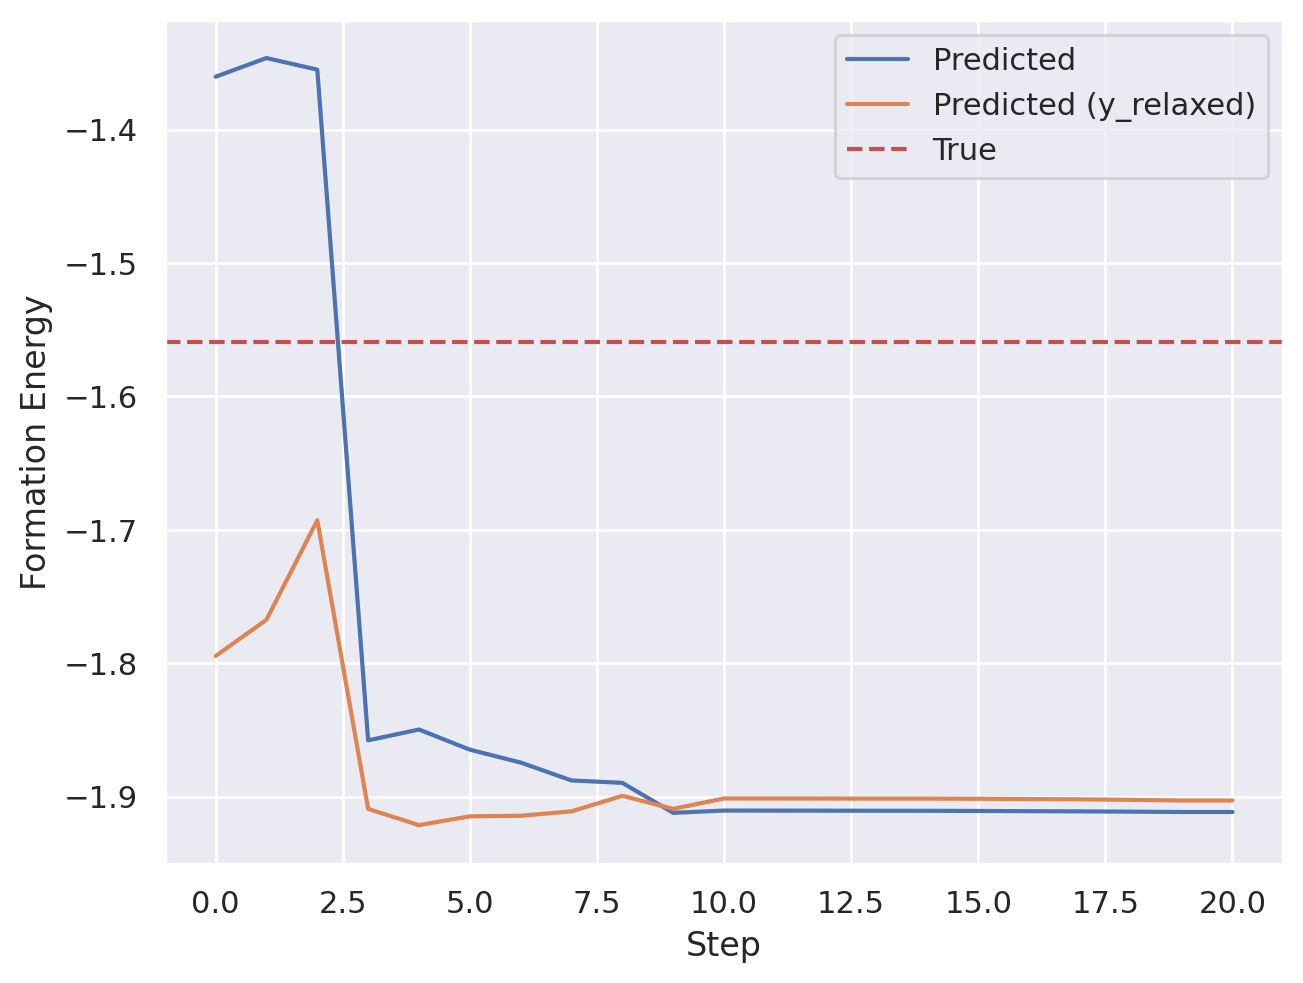

In [44]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme()


def compute_relaxed(
    sample: ProblematicSample,
):
    relax_out = sample["relax_out"]

    initial_data = move_data_to_device(
        copy.deepcopy(sample["initial_data"]), model.device
    )
    data = move_data_to_device(copy.deepcopy(sample["initial_data"]), model.device)

    for f in tqdm(relax_out.trajectory.frames):
        data.pos = f.pos.type_as(data.pos).reshape_as(data.pos).to(data.pos.device)
        data.cell = f.cell.type_as(data.cell).reshape_as(data.cell).to(data.cell.device)

        out = model_fn(data, initial_data, use_y_relaxed=True)
        yield out["energy"].item()


def plot_energy_vs_steps(
    sample: ProblematicSample,
    ax: plt.Axes | None = None,
):
    initial_data = sample["initial_data"]
    relax_out = sample["relax_out"]

    e_form_true = initial_data.y_formation.item()
    e_form_pred = [f.energy.item() for f in relax_out.trajectory.frames]
    e_form_pred_relaxed = None
    if True:
        e_form_pred_relaxed = list(compute_relaxed(sample))

    if ax is None:
        _, ax = plt.subplots()
    ax.plot(e_form_pred, label="Predicted")
    if e_form_pred_relaxed:
        ax.plot(e_form_pred_relaxed, label="Predicted (y_relaxed)")
    ax.axhline(y=e_form_true, color="r", linestyle="--", label="True")
    ax.set_xlabel("Step")
    ax.set_ylabel("Formation Energy")
    ax.legend()


plot_energy_vs_steps(problematic_samples[5])